# Uncertainty on market shares

In [315]:
import brightway2 as bw
import bw2calc as bc
import bw2data as bd
import numpy as np
import pandas as pd
import presamples as ps
import scipy
import scipy.stats as stats
from functions import make_dirichlet_distribution, get_elec_input, create_presamples, query_for_activities
ps.__version__

(0, 2, 6)

In [ ]:
from presamples import array

def custom_sample(self, index):
    """Draw a new sample from the pre-sampled arrays sequentially not randomly. The original code draws samples randomly. """
    index_ordered = self.count % self.data[0].shape[1]
    result = np.hstack([arr[:, index_ordered] for arr in self.data])
    self.count += 1   
    return result


array.RegularPresamplesArrays.sample = custom_sample

In [316]:
bw.projects.set_current("UK-wood-clca")
cutoff391 = bw.Database('cutoff-3.9.1')

test = bw.Database('mydb3')

fu = test.get('0cf1f43a31e143b5bc5c06f8979f08b8')


all_demands = [{fu: 1}]
d_label = ["fu"]

methods = [
     ('ReCiPe 2016 v1.03, midpoint (H)', 'climate change', 'global warming potential (GWP1000)'), 
]

In [318]:
fu.get('classifications', [])

[]

# Initialising monte calro lca

In [319]:
from bw_helpers import sample_results, MyMonteCarloLCA, collect_results

In [320]:
%%time
all_demand_dict = all_demands[0].copy()
for other_demand in all_demands[1:]:
    all_demand_dict.update(other_demand)

db = ['mydb']

indices = [1,1]

clca = MyMonteCarloLCA(all_demand_dict, 
                               method=methods[0], 
                               #presamples = presample,
                               final_activities=[],
                               database_name = db, 
                               tech_indices=None,
                               bio_indices=None,
                               include_only_specific_bio_uncertainty= True, 
                               include_only_specific_exc_uncertainty = True,
                               seed =False)
next(clca)


CPU times: total: 156 ms
Wall time: 167 ms


9.999999905005097

# Load results of recursive calulcation

In [321]:
indices = pd.read_csv(r'..\..\GSA_markets\markets_to_screen\test_indices.csv')

In [322]:
indices_list = list(indices.itertuples(index=False, name=None))

In [323]:
duplicate_activities_removed = list(set(indices_list))

In [324]:
activities =[]
for i in range(len(duplicate_activities_removed)):
    db = bw.Database(duplicate_activities_removed[i][0])
    activity = db.get(duplicate_activities_removed[i][1])
    activities.append(activity)

In [325]:
len(activities)

2

In [326]:
activities

['market 1' (unit, GLO, None), 'market 0' (unit, GLO, None)]

# Query exchanges

Find all the exchanges of the selected activities. Filter and exclude any exchange that should not be sampled.

In [327]:
exchanges= MyMonteCarloLCA.get_exchanges_of_activity_wo_category(clca, activities)
len(exchanges)

6

In [328]:
exchanges_units_sorted = [exc for exc in exchanges if exc['exchange']['unit'] == exc['activity']['unit']]
len(exchanges_units_sorted)

6

In [329]:
exchanges = [exc for exc in exchanges_units_sorted if exc['tech_indices'][0] != exc['tech_indices'][1] ]
len(exchanges)

4

In [330]:
activities =[]
for exc in exchanges:
    activities.append(exc["activity"])

## Morris sampling

In [331]:
activity_to_group = {}
group_counter = 1

for entry in exchanges:
    activity = entry['activity']
    if activity not in activity_to_group:
        activity_to_group[activity] = group_counter
        group_counter += 1
    # Add the group field to the entry
    entry['group'] = activity_to_group[activity]


In [332]:
def define_problem(input_data):
    # Initialize the output structure
    result = {
 #      'groups': [],
        'names': [],
        'num_vars': 0,
        'bounds': [],
        'sample_scaled': True
    }
    print(input_data)

    # Iterate over the input data
    for item in input_data:
        # Generate the 'name' as a string combining 'exchange' and 'activity'
        name = f"{item['exchange']}  to {item['activity']}"
        result['groups']= ( 'M1 mix', 'M1 mix',   'M0 mix',
                           'M0 mix', )
        result['names'].append(name)
        result['num_vars'] = len(input_data)
        if item['value']== 0.5:
            bounds = [item['value']-0.5, item['value']+0.5]
        else:
            bounds = [item['value']-item['value']*1, item['value']+item['value']*1]
        result['bounds'].append(bounds)
    
    return result

### Define problem

In [333]:
problem ={'names': ["ILR_F1", "ILR_F2"],
 'num_vars': 2,
 'bounds': [[-5,5], [-0.001,0.0001]],
 'sample_scaled': True,
 'groups': ('M0', 'M1')
         }

### Sample X

In [334]:
import numpy as np

def ilr_inverse(ilr_coords):
    """Inverse ALR transformation."""
    D = len(ilr_coords) + 1  # Since ALR uses D-1 coordinates
    x = np.zeros(D)  # Array to store the original composition
    
    # Exponentiate the ALR coordinates and set the last component as 1
    x[:-1] = np.exp(ilr_coords)
    x[-1] = 1 # The last component is the reference, so we don't need to change it
    
    # Normalize the components to sum to 1
    return x / np.sum(x)
    

In [335]:
trajectories = [100, 200, 300, 400, 500]

In [336]:
from SALib.sample.morris import sample
X = {}
X_without_zeros= {}
ratio_samples = {}
samples_analyse={}
samples_dict={}
for trajectory in trajectories:
    morris_samples = sample(problem, trajectory, 4)
    samples = pd.DataFrame(x).T
    samples_analyse[trajectory] =morris_samples.copy()
    samples_without_zeros = []
    samples = []
    for ilr_values in morris_samples:
        # Split ILR values by group
        ilr_m1 = ilr_values[:1]  # First two are fossil ILRs
        ilr_m0 = ilr_values[1:]  # Last four are waste ILRs


        m1_composition = ilr_inverse(ilr_m1)
        m0_composition = ilr_inverse(ilr_m0)  
        x = np.concatenate([m1_composition, m0_composition])
        x = np.array(x).T
        samples.append(x)
    samples = pd.DataFrame(samples).T
    samples_with_zeros = np.insert(samples, [0, 0], 0, axis=1)

    X[trajectory] = np.array(samples_with_zeros)
    X_without_zeros[trajectory] = np.array(samples)
    ratio_samples[trajectory] = morris_samples
    samples_dict[trajectory] =samples

In [337]:
samples_dict[300]

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.006693,0.006693,0.841131,0.006693,0.006693,0.841131,0.841131,0.006693,0.006693,0.158869,...,0.158869,0.993307,0.158869,0.158869,0.158869,0.158869,0.993307,0.158869,0.993307,0.993307
1,0.993307,0.993307,0.158869,0.993307,0.993307,0.158869,0.158869,0.993307,0.993307,0.841131,...,0.841131,0.006693,0.841131,0.841131,0.841131,0.841131,0.006693,0.841131,0.006693,0.006693
2,0.499750,0.499933,0.499933,0.500025,0.499842,0.499842,0.500025,0.500025,0.499842,0.499933,...,0.499750,0.500025,0.500025,0.499842,0.499933,0.499750,0.499750,0.499842,0.499842,0.500025
3,0.500250,0.500067,0.500067,0.499975,0.500158,0.500158,0.499975,0.499975,0.500158,0.500067,...,0.500250,0.499975,0.499975,0.500158,0.500067,0.500250,0.500250,0.500158,0.500158,0.499975


# update value with dirichlet distribution

For each activity, the quantity (value) of exchanges is updated in `exc_ dict` so that they sum to 1. 

`ext_dict` is a dictionnary that stores exchange names, their indices, their quantity (value) and their source activity.

The values summing to one are sampled using dirichlet distribution (N= mc) with different `concentration values`.
For each `concentration value` a new `exc_dict` is stored.  

In [338]:
%%time
results_normalized ={}
for trajectory, samples in X.items():
    new_samples_normalized = [
        {
            'trajectory': trajectory,
            'runs': len(X[trajectory][j]),
            'indices': exc['tech_indices'],
            'activity': exc['activity'],
            'exchange': exc['exchange'],
            'exc_database': exc['database'],
            'act_database': exc['activity'][0],
            'sample': X[trajectory][j],
            'old_value': exc['value'],
            #'index': i
        }
        for j, exc in enumerate(exchanges)
]
    results_normalized[trajectory] = new_samples_normalized


#results_normalized.extend(new_samples_normalized)
#all_results = pd.DataFrame(new_samples_normalized)

CPU times: total: 0 ns
Wall time: 0 ns


# create presamples

A presample is created for each `exc_dict`.

In [339]:
%%time
presamples_data_normalized = {}
presamples_indices_normalized = {}  

for trajectory, samples in results_normalized.items():  # Assuming results_normalized is a dictionary
    presamples_data_normalized[trajectory] = []  # Initialize empty list for this trajectory
    presamples_indices_normalized[trajectory] = []  # Initialize empty list for this trajectory
    
    for exc in samples:
        process = bw.Database(exc['exc_database']).get(exc['exchange'][1])
        activity = bw.Database(exc['act_database']).get(exc['activity'][1])
        value = exc['sample']

        data, indices = create_presamples(
            activity=activity,
            process=process,
            exchanges={
                "new_exchange": process,
                "new_value": lambda process: value
            }
        )

        presamples_data_normalized[trajectory].append(data)
        presamples_indices_normalized[trajectory].append(indices)

    presamples_data_normalized[trajectory] = np.vstack(presamples_data_normalized[trajectory])
    #presamples_data_dict_normalized[trajectory] = presamples_data_normalized[trajectory]
    #presamples_indices_dict_normalized[trajectory] = presamples_indices_normalized[trajectory]

CPU times: total: 31.2 ms
Wall time: 28.4 ms


In [340]:
index_matrix_data = {}
for trajectory, samples in results_normalized.items():
    index_matrix_data_normalized = [
        (globals()[f'presamples_data_normalized'][trajectory], 
         globals()[f'presamples_indices_normalized'][trajectory], 'technosphere')
    ]
    
    index_id_normalized, index_path_normalized = ps.create_presamples_package(
        matrix_data=index_matrix_data_normalized,
    )
    
    index_matrix_data[trajectory] = {
        'data': index_matrix_data_normalized,
        'index_id': index_id_normalized,
        'index_path': index_path_normalized
    }
    
    globals()[f'index_id_normalized_{trajectory}'] = index_id_normalized
    globals()[f'index_path_normalized_{trajectory}'] = index_path_normalized


# LCA calculations

In [341]:
presamples = [{"name": size, "runs": len(X[size][0]), "path": [globals()[f'index_path_normalized_{size}']], "number": "all"} for size in trajectories]

In [342]:
for size in trajectories:
    print(size)

100
200
300
400
500


In [343]:
%%time
import time

indices = []
results = []
final_activities = []
component_order = []

results_by_name = {}

for presample in presamples:
    start_time = time.time()

    clca = MyMonteCarloLCA(
        all_demand_dict,
        method=methods[0],
        presamples=presample["path"],
        final_activities=final_activities,
        database_name=db,
        bio_indices=None,
        tech_indices=None,
        include_only_specific_bio_uncertainty=True,
        include_only_specific_exc_uncertainty=True,
    )

    next(clca)

    temp_results = collect_results(
        clca,
        all_demands,
        final_activities,
        len(X_without_zeros[presample["name"]][0]),
        methods[0],
        d_label,
        component_order,
        database_name=db,
        bio_indices=None,
        tech_indices=None,
        include_only_specific_bio_uncertainty=True,
        include_only_specific_exc_uncertainty=True,
    )

    end_time = time.time()
    runtime = end_time - start_time

    temp_results["category"] = presample["name"]
    temp_results["runtime"] = runtime 
    temp_results["runs"] = presample["runs"]

    results_by_name[presample["name"]] = temp_results


morris_results = pd.concat(results_by_name)

CPU times: total: 17.7 s
Wall time: 7.73 s


In [344]:
#morris_results.to_csv(r'..\..\GSA_markets\results\Simple_global_scores_morris.csv', index=False)

In [345]:
X

{100: array([[0.        , 0.        , 0.1588691 , ..., 0.8411309 , 0.8411309 ,
         0.00669285],
        [0.        , 0.        , 0.8411309 , ..., 0.1588691 , 0.1588691 ,
         0.99330715],
        [0.        , 0.        , 0.49975   , ..., 0.49993333, 0.49975   ,
         0.49975   ],
        [0.        , 0.        , 0.50025   , ..., 0.50006667, 0.50025   ,
         0.50025   ]]),
 200: array([[0.        , 0.        , 0.8411309 , ..., 0.00669285, 0.00669285,
         0.8411309 ],
        [0.        , 0.        , 0.1588691 , ..., 0.99330715, 0.99330715,
         0.1588691 ],
        [0.        , 0.        , 0.500025  , ..., 0.49984167, 0.500025  ,
         0.500025  ],
        [0.        , 0.        , 0.499975  , ..., 0.50015833, 0.499975  ,
         0.499975  ]]),
 300: array([[0.        , 0.        , 0.00669285, ..., 0.1588691 , 0.99330715,
         0.99330715],
        [0.        , 0.        , 0.99330715, ..., 0.8411309 , 0.00669285,
         0.00669285],
        [0.        , 

# Sensitivity analysis

In [346]:
from SALib.analyze.morris import analyze
SA_results={}
for trajectory in trajectories:
    LCIA = morris_results[morris_results['category']== trajectory]
    samples_copy = np.array(samples_dict[trajectory].transpose(), dtype=np.float64)
    SA_normalized = analyze(problem, samples_analyse[trajectory], np.array(LCIA['score']), 
                            conf_level=0.95,  
                            print_to_console=False, 
                        
                           
          )

    SA_results[trajectory] = pd.DataFrame(SA_normalized)

2
2
2
2
2


In [347]:
len(samples_analyse[100])

300

In [348]:
for key in SA_results:
    SA_results[key]['names'] = ['M0', 'M1']

In [349]:
SA_results_df = pd.concat([df.assign(index=k) for k, df in SA_results.items()])

In [350]:
SA_results_df

,names,mu,mu_star,sigma,mu_star_conf,index
0,M0,-3.439094,3.864791,5.870855,1.077787,100
1,M1,2.546915,10.614937,11.190950,0.806280,100
0,M0,-3.419205,3.691681,5.690966,0.788237,200
1,M1,0.265244,9.459937,10.713287,0.677518,200
0,M0,-3.560655,3.833195,5.808098,0.597253,300
1,M1,-0.615526,9.585289,10.855527,0.623772,300
0,M0,-2.909671,3.227516,5.442676,0.525279,400
1,M1,-0.056775,9.701517,10.922936,0.488501,400
0,M0,-3.076660,3.307476,5.411159,0.481717,500
1,M1,-0.455506,9.595997,10.820478,0.462655,500


In [351]:
#SA_results_df.to_csv(r'..\..\GSA_markets\results\Simple_global_results_morris.csv', index=False)

# Plots

In [352]:
import matplotlib as mpl
import seaborn.objects as so
import matplotlib.pyplot as plt

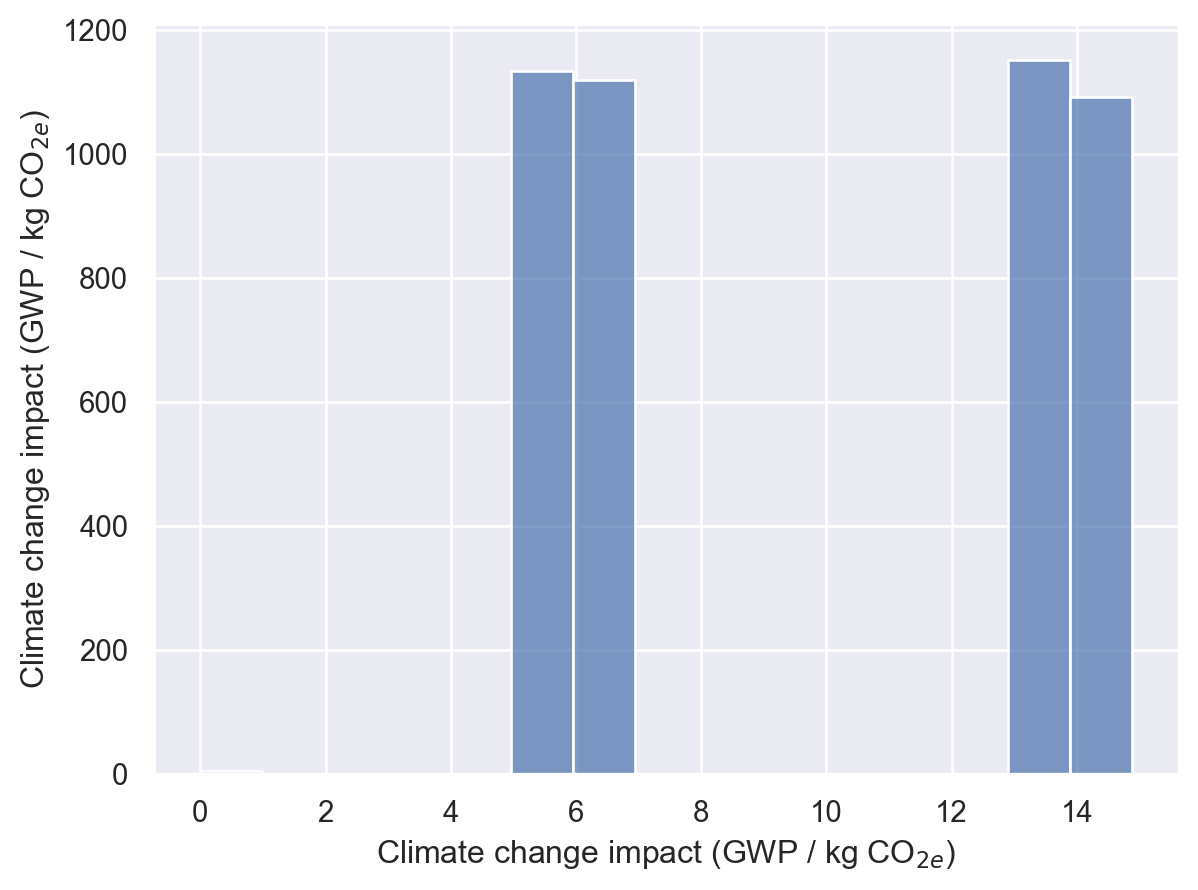

In [353]:
p = (
    so.Plot(morris_results, x="score")
    .add(so.Bars(), so.Hist())
 #   .layout(size=(3, 2))
)
p.label(x="Climate change impact (GWP / kg CO$_{2e}$)", y="Climate change impact (GWP / kg CO$_{2e}$)", color="")